# Featurization

As we saw with the difference between the Pearson correlation coefficient and Spearman correlation coefficient, the way we choose to numerical represent our data matters for the kinds of conclusions that we might be search for. "Featurization" is the process of taking real world, often tabular, and turning it into numerical values to calculate things like correlation.

## Categorical Data
Let's consider the example from assignment 1, where we have a voter roll and two surveys. Here is some code that loads the data and combines the dataset together:

In [4]:
import pandas as pd

voter_roll = pd.read_csv('voters.csv')
survey_monkey = pd.read_csv('survey_monkey.csv')
qualtrics = pd.read_csv('qualtrics.csv')


#the voter roll contains duplicate names due to a bug (my fault :( ), let's remove them
def remove_duplicate_rows(df):
    #get counts per name
    name_cts = df.groupby('Voter')['Voter'].count()
    
    #find all counts greater than or equal to 2
    dups = name_cts[name_cts >= 2]
    
    indexes_to_remove = []
    for d in dups.index:
        dup_pair = voter_roll[ voter_roll['Voter'] == d]
        first_index = dup_pair.index[0]
        indexes_to_remove.append(first_index)
    
    df_cpy = df.drop(indexes_to_remove)
    return df_cpy

#merge the datasets
voter_roll = remove_duplicate_rows(voter_roll)
survey_monkey = survey_monkey.merge(voter_roll, on='Voter')
qualtrics = qualtrics.merge(voter_roll, on='Voter')

combined_dataset = pd.concat([survey_monkey, qualtrics])
combined_dataset[:5]

,Voter,Vote,Gender,Age,County
0,Robert Wiltse,Genevieve Gallegos,male,46-55,Mountain Farm
1,Ellen Delrio,Pearle Goodman,female,56-65,Mountain Farm
2,Armando Dawson,Genevieve Gallegos,male,65+,Mountain Farm
3,Sarah Ybarra,Masako Holley,female,56-65,Mountain Farm
4,Roger Taylor,Genevieve Gallegos,male,46-55,Mountain Farm


Let's try to understand how gender correlates with candidate. We can do this inuitively by breaking down the variables:

In [6]:
combined_dataset.groupby(['Vote', 'Gender'])['Vote', 'Gender'].count()

Vote  Gender
Vote               Gender              
Genevieve Gallegos female     7       7
                   male      73      73
Masako Holley      female    36      36
                   male      24      24
Pearle Goodman     female     1       1
                   male       9       9

However, what if we wanted to have a measure for how strong this correlation is? For any categorical variable, we can create dummy binary cols that encode the presence of each of the possible values it could take. For example,

In [7]:
combined_dataset['voted_for_g'] = 1.0*(combined_dataset['Vote'] == 'Genevieve Gallegos')
combined_dataset['voted_for_m'] = 1.0*(combined_dataset['Vote'] == 'Masako Holley')
combined_dataset['voted_for_p'] = 1.0*(combined_dataset['Vote'] == 'Pearle Goodman')

combined_dataset['gender_m'] =  1.0*(combined_dataset['Gender'] == 'male')
combined_dataset['gender_f'] =  1.0*(combined_dataset['Gender'] == 'female')
combined_dataset[:5]

,Voter,Vote,Gender,Age,County,voted_for_g,voted_for_m,voted_for_p,gender_m,gender_f
0,Robert Wiltse,Genevieve Gallegos,male,46-55,Mountain Farm,1.0,0.0,0.0,1.0,0.0
1,Ellen Delrio,Pearle Goodman,female,56-65,Mountain Farm,0.0,0.0,1.0,0.0,1.0
2,Armando Dawson,Genevieve Gallegos,male,65+,Mountain Farm,1.0,0.0,0.0,1.0,0.0
3,Sarah Ybarra,Masako Holley,female,56-65,Mountain Farm,0.0,1.0,0.0,0.0,1.0
4,Roger Taylor,Genevieve Gallegos,male,46-55,Mountain Farm,1.0,0.0,0.0,1.0,0.0


The binary columns can be used to calculate numerical measures of correlation:

In [14]:
import scipy.stats
corr1 = scipy.stats.pearsonr(combined_dataset['voted_for_m'], combined_dataset['gender_m'])[0]
corr2 = scipy.stats.pearsonr(combined_dataset['voted_for_m'], combined_dataset['gender_f'])[0]
corr1, corr2

(0.11348924561549831, -0.11348924561549831)

In [15]:
scipy.stats.pearsonr(combined_dataset['gender_f'], combined_dataset['gender_m'])[0] #they are mutually exclusive!

-1.0

This type of encoding is called a One-Hot encoding and it is very useful for handling categorical variables with a small number of distinct values. We see that now we can calculate a meaningful correlation between categorical attributes.

## Binning Numerical Variables

The goal of featurization is how to represent data numerically to best use the quantitative tools at hand. This is even true if your data is already "numerical". Consider the following dataset that correlates Age with an Alzheimer Indicator:

In [49]:
df = pd.read_csv('alz.csv', delimiter=' ')
df[:5]

,Age,Ind
0,48,0.194743
1,56,0.363772
2,58,1.155571
3,46,0.995018
4,62,0.679212


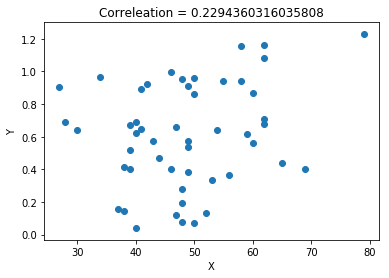

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

corr = scipy.stats.pearsonr(df['Age'],df['Ind'])[0]

plt.scatter(df['Age'],df['Ind'])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Correleation = '+ str(corr))
plt.show()

In [51]:
df['Age_binned'] = pd.cut(df['Age'], bins=4)
df[:5]

,Age,Ind,Age_binned
0,48,0.194743,"(40.0, 53.0]"
1,56,0.363772,"(53.0, 66.0]"
2,58,1.155571,"(53.0, 66.0]"
3,46,0.995018,"(40.0, 53.0]"
4,62,0.679212,"(53.0, 66.0]"


In [52]:
bins = pd.IntervalIndex.from_tuples([(0, 55), (55, 100)])
df['Age_binned'] = pd.cut(df['Age'], bins=bins)
df[:5]

,Age,Ind,Age_binned
0,48,0.194743,"(0, 55]"
1,56,0.363772,"(55, 100]"
2,58,1.155571,"(55, 100]"
3,46,0.995018,"(0, 55]"
4,62,0.679212,"(55, 100]"


In [53]:
bins = pd.IntervalIndex.from_tuples([(0, 40), (40, 54), (55,70), (70,100)])
df['Age_binned'], bins = pd.cut(df['Age'], bins=bins,retbins=True)
df[:5]

,Age,Ind,Age_binned
0,48,0.194743,"(40, 54]"
1,56,0.363772,"(55, 70]"
2,58,1.155571,"(55, 70]"
3,46,0.995018,"(40, 54]"
4,62,0.679212,"(55, 70]"


In [55]:
for b in bins:
    corr = scipy.stats.pearsonr(1.0*(df['Age_binned'] == b),df['Ind'])[0]
    print("Bin:", b, 'Corr=', corr )

Bin: (0, 40] Corr= -0.15927303133530316
Bin: (40, 54] Corr= -0.1889297871800505
Bin: (55, 70] Corr= 0.24388835227035674
Bin: (70, 100] Corr= 0.2786272366517293


## Dealing With String Data
Sometimes your data isn't numerical or categorical and it is simply string data like free form comments etc. Refer to the following references:

* https://en.wikipedia.org/wiki/Bag-of-words_model
* https://en.wikipedia.org/wiki/Tf%E2%80%93idf
* https://en.wikipedia.org/wiki/Word2vec

In [62]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
corpus = [
     'This is the first document.',
     'This is the second second document.',
     'And the third one.',
    'Is this the first document?']

X = vectorizer.fit_transform(corpus)
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [63]:
vectorizer.get_feature_names()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']